# Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid. Your goal is to uncover patterns that could inform smarter trading strategies.


In [1]:
import pandas as pd

In [4]:
df1= pd.read_csv("fear_greed_index.csv")
df2= pd.read_csv("historical_data.csv")

In [14]:
df1

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
...,...,...,...,...
2639,1745818200,54,Neutral,2025-04-28
2640,1745904600,60,Greed,2025-04-29
2641,1745991000,56,Greed,2025-04-30
2642,1746077400,53,Neutral,2025-05-01


In [55]:
df2.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# Data Preparation

In [17]:
#checking null values

df1.isnull().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

In [18]:
df2.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [25]:
#checking duplicate values

df1.duplicated().sum()

np.int64(0)

In [26]:
df2.duplicated().sum()

np.int64(0)

In [78]:
df2["Timestamp IST"] = df2["Timestamp IST"].dt.date
df1["date"] = pd.to_datetime(df1["date"]).dt.date

In [79]:
merged = df2.merge(df1, left_on="Timestamp IST", right_on="date", how="left")

In [59]:
df2["Direction"].value_counts()

Direction
Open Long                    49895
Close Long                   48678
Open Short                   39741
Close Short                  36013
Sell                         19902
Buy                          16716
Spot Dust Conversion           142
Short > Long                    70
Long > Short                    57
Auto-Deleveraging                8
Liquidated Isolated Short        1
Settlement                       1
Name: count, dtype: int64

In [80]:
daily_trader_stats = merged.groupby(["Account", "Timestamp IST"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    trade_count=("Trade ID", "count"),
    long_trades=("Direction", lambda x: (x.str.lower().str.contains("buy|long")).sum()),
    short_trades=("Direction", lambda x: (x.str.lower().str.contains("sell|short")).sum()),
    win_count=("Closed PnL", lambda x: (x > 0).sum()),
    loss_count=("Closed PnL", lambda x: (x < 0).sum()))

In [86]:
daily_trader_stats["win_rate"] = daily_trader_stats["win_count"] / daily_trader_stats["trade_count"]
daily_trader_stats["long_short_ratio"] = daily_trader_stats["long_trades"] / (daily_trader_stats["short_trades"])

# Analysis

In [82]:
daily_metrics = daily_trader_stats.merge(df1[["date", "classification"]], left_on="Timestamp IST", right_on="date", how="left")

In [83]:
daily_metrics

,daily_pnl,trade_count,long_trades,short_trades,win_count,loss_count,win_rate,long_short_ratio,date,classification
0,0.000000,177,0,177,0,0,0.000000,0.000000,2024-11-11,Extreme Greed
1,0.000000,68,0,68,0,0,0.000000,0.000000,2024-11-17,Extreme Greed
2,0.000000,40,0,40,0,0,0.000000,0.000000,2024-11-18,Extreme Greed
3,-21227.000000,12,0,12,0,12,0.000000,0.000000,2024-11-22,Extreme Greed
4,1603.100000,27,0,27,12,0,0.444444,0.000000,2024-11-26,Extreme Greed
...,...,...,...,...,...,...,...,...,...,...
2336,1709.194807,82,82,0,32,0,0.390244,inf,2025-04-27,Greed
2337,4008.588908,430,184,246,169,19,0.393023,0.747967,2025-04-28,Neutral
2338,8561.771838,902,0,902,398,34,0.441242,0.000000,2025-04-29,Greed
2339,2520.773814,75,62,14,39,0,0.520000,4.428571,2025-04-30,Greed


In [100]:
summary = daily_metrics.groupby("classification").agg(
    mean_pnl=("daily_pnl", "mean"),
    mean_win_rate=("win_rate", "mean"), 
    mean_trades=("trade_count", "mean"),
    mean_long_bias=("long_short_ratio", "mean") )

In [101]:
summary

,mean_pnl,mean_win_rate,mean_trades,mean_long_bias
classification,,,,
Extreme Fear,4619.439053,0.329659,133.750000,inf
Extreme Greed,5161.922644,0.386387,76.030418,inf
Fear,5328.818161,0.364033,98.153968,inf
Greed,3318.100730,0.343559,77.628086,inf
Neutral,3438.618818,0.355414,100.228723,inf


Text(0, 0.5, 'long short ratio')

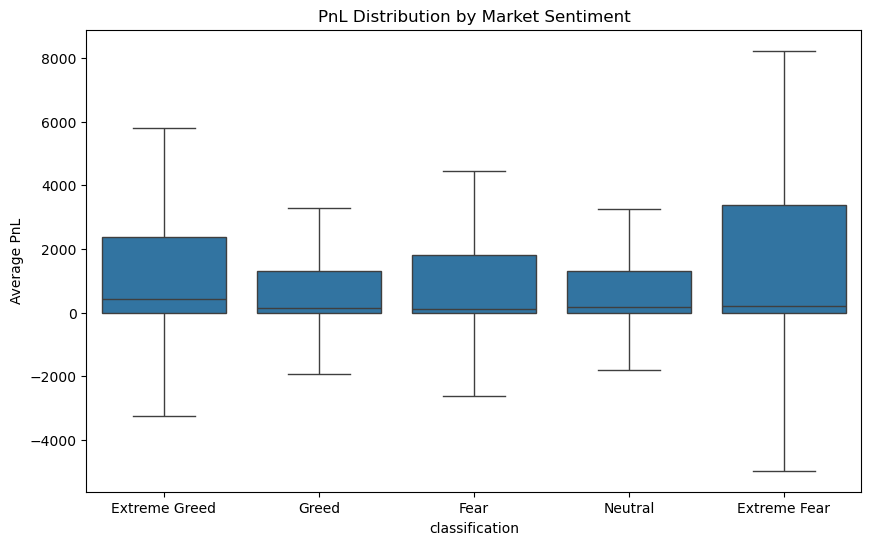

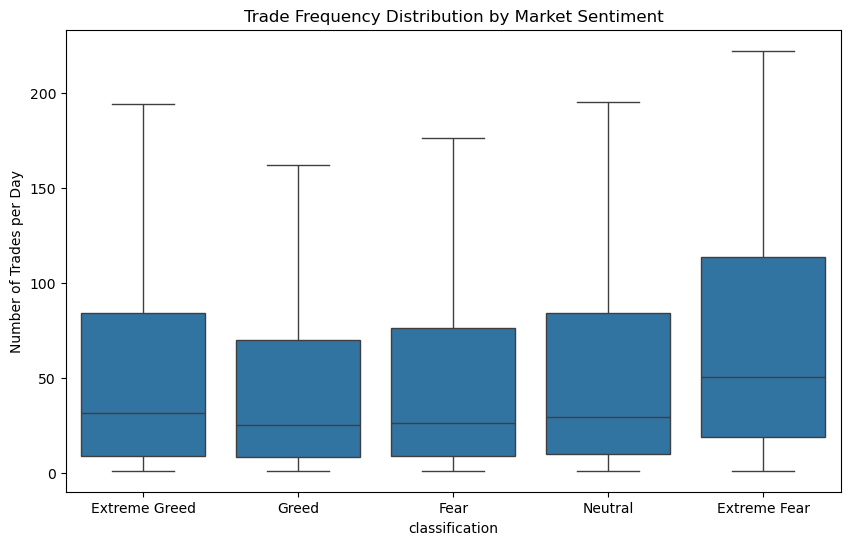

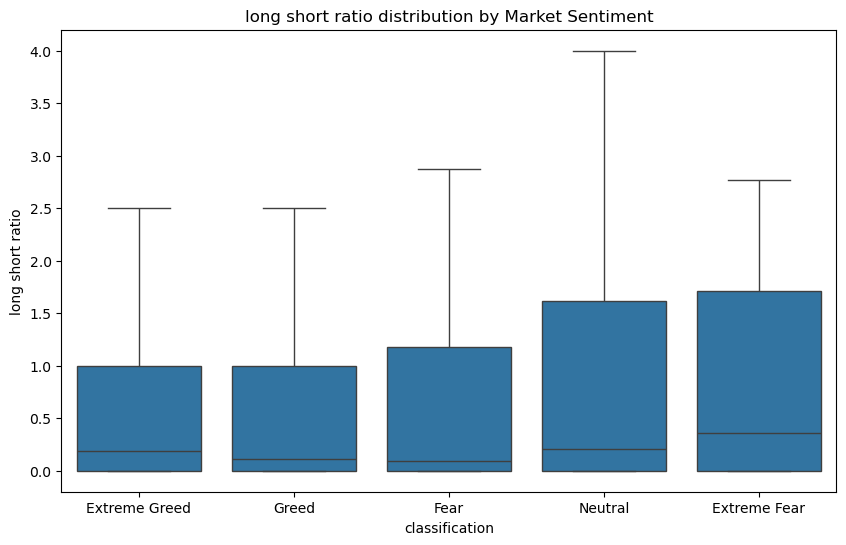

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x="classification", y="daily_pnl", data=daily_metrics, showfliers=False)
plt.title("PnL Distribution by Market Sentiment")
plt.ylabel("Average PnL")

plt.figure(figsize=(10, 6))
sns.boxplot(x="classification", y="trade_count", data=daily_metrics, showfliers=False)
plt.title("Trade Frequency Distribution by Market Sentiment")
plt.ylabel("Number of Trades per Day")

plt.figure(figsize=(10, 6))
sns.boxplot(x="classification", y='long_short_ratio', data=daily_metrics, showfliers=False)
plt.title("long short ratio distribution by Market Sentiment")
plt.ylabel("long short ratio")

# Insight 1
# Traders in this dataset generated their highest average daily profits during Extreme Fear

# Insight 2

# The "Greed Trap" - During Greed days, trade frequency drops compared to Fear days, and average daily PnL decreases. 

# Insight 3

# In Extreme Fear, Traders are more on long side as seen in the chart